In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Data Loader

In [7]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:17<00:00, 2.19MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [11]:
batch_size = 100

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Visualize few image

In [14]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


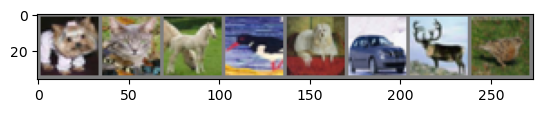

In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:8]))

In [18]:
labels[:8]

tensor([5, 3, 7, 2, 5, 1, 4, 2])

In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [22]:
[classes[i] for i in labels[:8]]

['dog', 'cat', 'horse', 'bird', 'dog', 'car', 'deer', 'bird']

### Train a neural network}

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding='same'),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),        # Output: (32, 16, 16)
            
            nn.Conv2d(32, 64, kernel_size=(3,3)),             # Output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))         # Output: (64, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Flatten to (64 * 7 * 7 = 3136)
            nn.Linear(64 * 7 * 7, 600),                  # Corrected input size
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
        
    def forward(self, x):
        x = self.network(x)
        x = self.fc_layers(x)
        return x

In [27]:
model = CNN()
dummy_input = torch.randn(1, 3, 32, 32)  # Single example with CIFAR-10 dimensions
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be [1, 10]

Output shape: torch.Size([1, 10])


In [29]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%")

Epoch [1/10], Step [100/500], Loss: 1.4962
Epoch [1/10], Step [200/500], Loss: 1.3073
Epoch [1/10], Step [300/500], Loss: 1.3324
Epoch [1/10], Step [400/500], Loss: 1.3925
Epoch [1/10], Step [500/500], Loss: 1.2912
Epoch [2/10], Step [100/500], Loss: 0.9801
Epoch [2/10], Step [200/500], Loss: 0.8338
Epoch [2/10], Step [300/500], Loss: 0.9297
Epoch [2/10], Step [400/500], Loss: 0.8295
Epoch [2/10], Step [500/500], Loss: 0.8886
Epoch [3/10], Step [100/500], Loss: 0.7466
Epoch [3/10], Step [200/500], Loss: 0.8743
Epoch [3/10], Step [300/500], Loss: 0.8327
Epoch [3/10], Step [400/500], Loss: 0.6513
Epoch [3/10], Step [500/500], Loss: 0.6383
Epoch [4/10], Step [100/500], Loss: 0.5109
Epoch [4/10], Step [200/500], Loss: 0.5591
Epoch [4/10], Step [300/500], Loss: 0.5353
Epoch [4/10], Step [400/500], Loss: 0.5135
Epoch [4/10], Step [500/500], Loss: 0.5855
Epoch [5/10], Step [100/500], Loss: 0.4399
Epoch [5/10], Step [200/500], Loss: 0.5892
Epoch [5/10], Step [300/500], Loss: 0.3392
Epoch [5/10